In [ ]:
from tqdm import tqdm
from collections import Counter
from nlp_project.data import json_to_Dataset_ensemble

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    DistilBertForTokenClassification,
    AlbertForTokenClassification,
)

all_labels = [
    "B-STREET",
    "B-CITY",
    "I-DATE",
    "B-PASS",
    "I-CITY",
    "B-TIME",
    "B-EMAIL",
    "I-DRIVERLICENSE",
    "I-POSTCODE",
    "I-BOD",
    "B-USERNAME",
    "B-BOD",
    "B-COUNTRY",
    "B-SECADDRESS",
    "B-IDCARD",
    "I-SOCIALNUMBER",
    "I-PASSPORT",
    "B-IP",
    "O",
    "B-TEL",
    "B-SOCIALNUMBER",
    "I-TIME",
    "B-BUILDING",
    "B-PASSPORT",
    "I-TITLE",
    "I-SEX",
    "I-STREET",
    "B-STATE",
    "I-STATE",
    "B-TITLE",
    "B-DATE",
    "B-GEOCOORD",
    "I-IDCARD",
    "I-TEL",
    "B-POSTCODE",
    "B-DRIVERLICENSE",
    "I-GEOCOORD",
    "I-COUNTRY",
    "I-EMAIL",
    "I-PASS",
    "B-SEX",
    "I-USERNAME",
    "I-BUILDING",
    "I-IP",
    "I-SECADDRESS",
    "B-CARDISSUER",
    "I-CARDISSUER",
]

id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
n_labels = len(all_labels)

distil_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [3]:
# Define a custom collate function to pad batched sequences
def collate_batch(batch):
    # Determine max lengths for padding
    max_len_distil = max(len(item["distilbert_inputids"]) for item in batch)
    max_len_albert = max(len(item["albert_inputids"]) for item in batch)
    max_len_words = max(len(item["spacy_labels"]) for item in batch)
    # Pad input_ids and attention_mask for distil and albert
    input_ids_distil_batch, attention_mask_distil_batch = [], []
    input_ids_albert_batch, attention_mask_albert_batch = [], []
    labels_distil_batch, labels_albert_batch = [], []
    word_ids_distil_batch, word_ids_albert_batch = [], []
    word_labels_batch = []
    for item in batch:
        # Pad DistilBERT inputs
        ids = item["distilbert_inputids"] + [distil_tokenizer.pad_token_id] * (
            max_len_distil - len(item["distilbert_inputids"])
        )
        mask = item["distilbert_attention_masks"] + [0] * (
            max_len_distil - len(item["distilbert_attention_masks"])
        )
        labels_d = item["distilbert_token_labels"] + [-100] * (
            max_len_distil - len(item["distilbert_token_labels"])
        )
        # Pad ALBERT inputs
        ids_a = item["albert_inputids"] + [albert_tokenizer.pad_token_id] * (
            max_len_albert - len(item["albert_inputids"])
        )
        mask_a = item["albert_attention_masks"] + [0] * (
            max_len_albert - len(item["albert_attention_masks"])
        )
        labels_a = item["albert_token_labels"] + [-100] * (
            max_len_albert - len(item["albert_token_labels"])
        )
        # Pad word_ids mapping (use -1 for padding positions for clarity)
        word_ids_d = item["distilbert_wordids"] + [None] * (
            max_len_distil - len(item["distilbert_wordids"])
        )
        word_ids_a = item["albert_wordids"] + [None] * (
            max_len_albert - len(item["albert_wordids"])
        )
        # Pad word-level labels
        w_labels = item["spacy_labels"] + [-100] * (
            max_len_words - len(item["spacy_labels"])
        )
        # Collect padded items
        input_ids_distil_batch.append(torch.tensor(ids))
        attention_mask_distil_batch.append(torch.tensor(mask))
        labels_distil_batch.append(torch.tensor(labels_d))
        word_ids_distil_batch.append(
            word_ids_d
        )  # keep as list of None/idx (non-tensor for now)
        input_ids_albert_batch.append(torch.tensor(ids_a))
        attention_mask_albert_batch.append(torch.tensor(mask_a))
        labels_albert_batch.append(torch.tensor(labels_a))
        word_ids_albert_batch.append(word_ids_a)
        word_labels_batch.append(torch.tensor(w_labels))
    # Stack all batches
    batch_tensors = {
        "distilbert_inputids": torch.stack(input_ids_distil_batch),
        "distilbert_attention_masks": torch.stack(attention_mask_distil_batch),
        "distilbert_token_labels": torch.stack(labels_distil_batch),
        "distilbert_wordids": word_ids_distil_batch,  # list of lists (will be used in model forward)
        "albert_inputids": torch.stack(input_ids_albert_batch),
        "albert_attention_masks": torch.stack(attention_mask_albert_batch),
        "albert_token_labels": torch.stack(labels_albert_batch),
        "albert_wordids": word_ids_albert_batch,
        "spacy_labels": torch.stack(word_labels_batch),
    }
    return batch_tensors

In [51]:
train_encodings = json_to_Dataset_ensemble("datasets/ensemble_train.json")
bs = 4

In [70]:
distilbert = DistilBertForTokenClassification.from_pretrained(
    "models/distilbert1",
    num_labels=len(all_labels),
    label2id=label2id,
    id2label=id2label,
)
albert = AlbertForTokenClassification.from_pretrained(
    "models/albert1",
    num_labels=len(all_labels),
    label2id=label2id,
    id2label=id2label,
)

In [ ]:
input_ids_distil = train_encodings[0:bs]["distilbert_inputids"]
input_ids_albert = train_encodings[0:bs]["albert_inputids"]
attention_mask_distil = train_encodings[0:bs]["distilbert_attention_masks"]
attention_mask_albert = train_encodings[0:bs]["albert_attention_masks"]
distil_word_ids = train_encodings[0:bs]["distilbert_wordids"]
albert_word_ids = train_encodings[0:bs]["albert_wordids"]
labels = train_encodings[0:bs]["spacy_labels"]

In [142]:
train_loader = DataLoader(
    train_encodings, batch_size=4, shuffle=False, collate_fn=collate_batch
)
for batch in train_loader:
    # distilbert(input_ids=input_ids_distil, attention_mask=attention_mask_distil)
    input_ids_distil = batch["distilbert_inputids"]
    input_ids_albert = batch["albert_inputids"]
    attention_mask_distil = batch["distilbert_attention_masks"]
    attention_mask_albert = batch["albert_attention_masks"]
    distil_word_ids = batch["distilbert_wordids"]
    albert_word_ids = batch["albert_wordids"]
    labels = batch["spacy_labels"]

    distil_outputs = distilbert(
        input_ids=input_ids_distil, attention_mask=attention_mask_distil
    )
    albert_outputs = albert(
        input_ids=input_ids_albert, attention_mask=attention_mask_albert
    )

    logits_distil = distil_outputs.logits
    logits_albert = albert_outputs.logits
    max_words = labels.size(1)

    print(max_words)
    print("batch 0: ", max([i for i in distil_word_ids[0] if i is not None]))
    print("batch 0: ", max([i for i in albert_word_ids[0] if i is not None]))
    print("batch 1: ", max([i for i in distil_word_ids[1] if i is not None]))
    print("batch 1: ", max([i for i in albert_word_ids[1] if i is not None]))
    print("batch 2: ", max([i for i in distil_word_ids[2] if i is not None]))
    print("batch 2: ", max([i for i in albert_word_ids[2] if i is not None]))
    print("batch 3: ", max([i for i in distil_word_ids[3] if i is not None]))
    print("batch 3: ", max([i for i in albert_word_ids[3] if i is not None]))
    print()
    print(
        "batch 0: ", len(set([i for i in distil_word_ids[0] if i is not None]))
    )
    print(
        "batch 0: ", len(set([i for i in albert_word_ids[0] if i is not None]))
    )
    print(
        "batch 1: ", len(set([i for i in distil_word_ids[1] if i is not None]))
    )
    print(
        "batch 1: ", len(set([i for i in albert_word_ids[1] if i is not None]))
    )
    print(
        "batch 2: ", len(set([i for i in distil_word_ids[2] if i is not None]))
    )
    print(
        "batch 2: ", len(set([i for i in albert_word_ids[2] if i is not None]))
    )
    print(
        "batch 3: ", len(set([i for i in distil_word_ids[3] if i is not None]))
    )
    print(
        "batch 3: ", len(set([i for i in albert_word_ids[3] if i is not None]))
    )
    print(logits_distil[0].shape)
    print(logits_albert[0].shape)

    # for i in range(4):
    #     print("logits_albert:", logits_albert[0][i])

    combined_logits = torch.zeros((bs, max_words, n_labels))

    for b in range(bs):
        distil_map = distil_word_ids[b]  # list of length seq_len_distil
        albert_map = albert_word_ids[b]  # list of length seq_len_albert

        print("distil_map:", distil_map)
        print("albert_map:", albert_map)

        count = 0
        for token_index, word_index in enumerate(distil_map):

            # if count == 2:
            #     break
            # count += 1

            if word_index is None:
                continue  # skip special tokens ([CLS], [SEP], etc.)
            # Take the first subtoken of each word for DistilBERT
            # (Only the first subtoken carries the label, others should be ignored)
            if (
                token_index > 0
                and distil_map[token_index] == distil_map[token_index - 1]
            ):
                # Skip subtokens that map to the same word as a previous token
                continue
            # Find the corresponding first subtoken from ALBERT mapping for the same word
            # We locate the first occurrence of this word index in ALBERT's token map
            try:
                albert_token_index = albert_map.index(word_index)
            except ValueError:
                # If the word index is not found in ALBERT's tokens (e.g., ALBERT truncated earlier),
                # skip averaging for this word.
                continue
            # Compute average of logits from both models for this word position
            combined_logits[b, word_index, :] = (
                logits_distil[b, token_index, :]
                + logits_albert[b, albert_token_index, :]
            ) / 2.0

        for i in range(4):
            print(len(combined_logits[i]))
            print(len(labels[i]))

        break
    break

130
batch 0:  84
batch 0:  84
batch 1:  72
batch 1:  72
batch 2:  74
batch 2:  74
batch 3:  129
batch 3:  129

batch 0:  79
batch 0:  79
batch 1:  65
batch 1:  65
batch 2:  60
batch 2:  60
batch 3:  112
batch 3:  112
torch.Size([140, 47])
torch.Size([222, 47])
distil_map: [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 69, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 73, 74, 75, 76, 76, 76, 76, 76, 76, 76, 78, 78, 79, 80, 81, 82, 84, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
albert_map: [None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 8, 10, 11, 12, 12, 14, 15, 16, 17, 18, 19, 20, 2

In [36]:
class CubeBert(nn.Module):
    def __init__(
        self,
        distilbert_model="distilbert-base-uncased",
        albert_model="albert-base-v2",
        freeze_backbones=True,
        labels_to_freeze_alpha=None,
        label2id=None,
        id2label=None,
    ):
        super(CubeBert, self).__init__()

        self.label2id = label2id
        self.id2label = id2label
        self.num_labels = len(label2id)

        self.distilbert = DistilBertForTokenClassification.from_pretrained(
            distilbert_model,
            num_labels=self.num_labels,
            label2id=label2id,
            id2label=id2label,
        )
        self.albert = AlbertForTokenClassification.from_pretrained(
            albert_model,
            num_labels=self.num_labels,
            label2id=label2id,
            id2label=id2label,
        )

        if freeze_backbones:
            for param in self.distilbert.parameters():
                param.requires_grad = False
            for param in self.albert.parameters():
                param.requires_grad = False

        self.alpha_logits = nn.Parameter(
            torch.zeros(self.num_labels)
        )  # α logits

        self.alpha_mask = torch.ones(self.num_labels)
        if labels_to_freeze_alpha:
            for label in labels_to_freeze_alpha:
                idx = label2id[label]
                self.alpha_logits.data[idx] = 10.0  # sigmoid(10) ≈ 1.0
                self.alpha_mask[idx] = 0.0  # frozen

    def forward(
        self,
        input_ids_distil,
        attention_mask_distil,
        input_ids_albert,
        attention_mask_albert,
        distil_word_ids=None,
        albert_word_ids=None,
        labels=None,
    ):

        distil_outputs = self.distilbert(
            input_ids=input_ids_distil, attention_mask=attention_mask_distil
        )
        albert_outputs = self.albert(
            input_ids=input_ids_albert, attention_mask=attention_mask_albert
        )

        logits_distil = distil_outputs.logits  # [B, T_distil, C]
        logits_albert = albert_outputs.logits  # [B, T_albert, C]

        batch_size = logits_distil.size(0)
        device = logits_distil.device
        num_labels = logits_distil.size(-1)

        raw_alpha = self.alpha_logits
        masked_alpha = torch.sigmoid(raw_alpha) * self.alpha_mask.to(
            device
        ) + torch.sigmoid(raw_alpha.detach()) * (
            1 - self.alpha_mask.to(device)
        )
        alpha = masked_alpha.view(1, 1, -1)  # shape [1, 1, C]

        if labels is not None:
            max_words = labels.size(1)
        else:
            max_words = (
                max(
                    [
                        max([wi for wi in d if wi is not None], default=0)
                        for d in distil_word_ids
                    ]
                )
                + 1
            )

        combined_logits = torch.zeros(
            (batch_size, max_words, num_labels), device=device
        )

        for b in range(batch_size):
            distil_map = distil_word_ids[b]
            albert_map = albert_word_ids[b]

            for token_index, word_index in enumerate(distil_map):
                if word_index is None:
                    continue
                if (
                    token_index > 0
                    and distil_map[token_index] == distil_map[token_index - 1]
                ):
                    continue
                try:
                    albert_token_index = albert_map.index(word_index)
                except ValueError:
                    continue

                if word_index >= combined_logits.shape[1]:
                    print(
                        f"[Warning] word_index {word_index} exceeds combined_logits shape {combined_logits.shape}"
                    )
                    continue

                d_logit = logits_distil[b, token_index]  # [C]
                a_logit = logits_albert[b, albert_token_index]  # [C]
                fused = alpha[0, 0] * d_logit + (1 - alpha[0, 0]) * a_logit
                combined_logits[b, word_index] = fused

                # Debug for STREET
                street_idx = self.label2id["B-STREET"]
                pred_label = torch.argmax(fused).item()

                if pred_label == street_idx or (
                    labels is not None and labels[b, word_index] == street_idx
                ):
                    print(f"\n[DEBUG - Batch {b}, Word {word_index}]")
                    print(
                        f"α[STREET]           : {alpha[0, 0, street_idx].item():.4f}"
                    )
                    print(
                        f"Distil logit        : {d_logit[street_idx].item():.2f}"
                    )
                    print(
                        f"ALBERT logit        : {a_logit[street_idx].item():.2f}"
                    )
                    print(
                        f"Fused logit         : {fused[street_idx].item():.2f}"
                    )
                    print(f"Predicted label     : {self.id2label[pred_label]}")
                    if labels is not None:
                        true = self.id2label[labels[b, word_index].item()]
                        print(f"True label          : {true}")

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(
                combined_logits.view(-1, num_labels), labels.view(-1)
            )

        return (
            {"logits": combined_logits, "loss": loss}
            if loss is not None
            else {"logits": combined_logits}
        )

In [48]:
train_encodings = json_to_Dataset_ensemble("datasets/ensemble_train.json")
val_encodings = json_to_Dataset_ensemble("datasets/ensemble_val.json")

In [50]:
cube_model = CubeBert(
    "models/distilbert1",
    "models/albert1",
    freeze_backbones=True,
    labels_to_freeze_alpha=["B-STREET", "I-STREET"],
    label2id=label2id,
    id2label=id2label,
)
device = "cuda"
train_loader = DataLoader(
    val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch
)
dev_loader = DataLoader(
    val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch
)

for i, batch in enumerate(dev_loader):
    if i > 0:
        break  # just one batch
    # Move inputs to device
    input_ids_distil = batch["distilbert_inputids"]
    attention_mask_distil = batch["distilbert_attention_masks"]
    input_ids_albert = batch["albert_inputids"]
    attention_mask_albert = batch["albert_attention_masks"]
    # We use the model without passing labels to get predictions
    with torch.no_grad():
        outputs = cube_model(
            input_ids_distil=input_ids_distil,
            attention_mask_distil=attention_mask_distil,
            input_ids_albert=input_ids_albert,
            attention_mask_albert=attention_mask_albert,
            distil_word_ids=batch["distilbert_wordids"],
            albert_word_ids=batch["albert_wordids"],
            labels=batch["spacy_labels"],
        )
    logits = outputs[
        "logits"
    ]  # shape: (batch_size, seq_len_words, num_labels)
    # Get predicted label IDs (highest logit) for each word
    pred_ids = (
        logits.argmax(dim=-1).cpu().numpy()
    )  # shape: (batch_size, seq_len_words)
    true_ids = (
        batch["spacy_labels"].cpu().numpy()
    )  # true label IDs with -100 for padding
    # Convert IDs to label names, ignoring any padding (-100)
    for i in range(len(pred_ids)):
        pred_seq = []
        true_seq = []
        for j in range(len(true_ids[i])):
            if true_ids[i][j] == -100:
                # Skip padded positions (no actual token)
                continue
            true_label_id = int(true_ids[i][j])
            pred_label_id = int(pred_ids[i][j])
            # Map IDs to label strings using id2label
            true_seq.append(id2label[true_label_id])
            pred_seq.append(id2label[pred_label_id])


[DEBUG - Batch 7, Word 24]
α[STREET]           : 1.0000
Distil logit        : 7.70
ALBERT logit        : 8.19
Fused logit         : 7.70
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 10, Word 73]
α[STREET]           : 1.0000
Distil logit        : 8.57
ALBERT logit        : 7.72
Fused logit         : 8.57
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 11, Word 49]
α[STREET]           : 1.0000
Distil logit        : 9.84
ALBERT logit        : 8.40
Fused logit         : 9.84
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 17, Word 9]
α[STREET]           : 1.0000
Distil logit        : 9.94
ALBERT logit        : 9.19
Fused logit         : 9.94
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 17, Word 93]
α[STREET]           : 1.0000
Distil logit        : 9.91
ALBERT logit        : 9.53
Fused logit         : 9.91
Predicted label     : B-STREET
True label          : B-STRE

In [54]:
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer


def compare_distil_logits_on_word(
    cube_model,
    val_loader,
    label2id,
    batch_index=22,
    word_index=58,
    device="cpu",
):

    print(
        f"\n🧪 Comparing logits on Batch {batch_index}, Word {word_index}..."
    )

    # Load standalone fine-tuned distilbert model
    standalone = AutoModelForTokenClassification.from_pretrained(
        "models/distilbert1"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    standalone.eval()
    cube_model.eval()

    # Get the batch (advance iterator up to batch_index)
    for i, batch in enumerate(val_loader):
        if i == batch_index:
            break

    # Move tensors to device
    input_ids = batch["distilbert_inputids"].to(device)
    attn_mask = batch["distilbert_attention_masks"].to(device)
    word_ids = batch["distilbert_wordids"]
    tokens = batch.get("tokens")  # optional, only if stored

    # Get logits from both models
    with torch.no_grad():
        cube_outputs = cube_model(
            input_ids_distil=input_ids,
            attention_mask_distil=attn_mask,
            input_ids_albert=batch["albert_inputids"].to(device),
            attention_mask_albert=batch["albert_attention_masks"].to(device),
            distil_word_ids=word_ids,
            albert_word_ids=batch["albert_wordids"],
            labels=batch["spacy_labels"].to(device),
        )
        cube_logits = cube_outputs["logits"]  # [B, W, C]

        standalone_logits = standalone(
            input_ids=input_ids, attention_mask=attn_mask
        ).logits  # [B, T, C]

    # Find token index in DistilBERT corresponding to word_index
    token_idx = None
    for i, wid in enumerate(word_ids[batch_index]):
        if wid == word_index:
            token_idx = i
            break

    if token_idx is None:
        print(
            "❌ Could not find a token in distil_word_ids matching that word index."
        )
        return

    # Index of B-STREET
    street_idx = label2id["B-STREET"]

    # Extract logits
    logit_cube = cube_logits[batch_index, word_index, street_idx].item()
    logit_standalone = standalone_logits[
        batch_index, token_idx, street_idx
    ].item()

    print(f"📍 Token index in DistilBERT: {token_idx}")
    print(
        f"🔢 Standalone DistilBERT logit for B-STREET: {logit_standalone:.4f}"
    )
    print(f"🧩 CubeBert Ensemble logit for B-STREET    : {logit_cube:.4f}")

    # Optional: show surrounding context
    print("\nContextual tokens:")
    decoded = tokenizer.convert_ids_to_tokens(
        input_ids[batch_index].cpu().tolist()
    )
    print(" ".join(decoded[max(0, token_idx - 5) : token_idx + 6]))

    # Optional: show predicted label
    pred_idx = torch.argmax(cube_logits[batch_index, word_index]).item()
    print(f"CubeBert prediction: {cube_model.id2label[pred_idx]}")

    true_id = batch["spacy_labels"][batch_index, word_index].item()
    if true_id != -100:
        print(f"Gold label         : {cube_model.id2label[true_id]}")


compare_distil_logits_on_word(
    cube_model=cube_model,
    val_loader=train_loader,
    label2id=label2id,
    batch_index=0,
    word_index=9,
    device="cpu",  # or "cpu"
)


🧪 Comparing logits on Batch 0, Word 9...

[DEBUG - Batch 4, Word 72]
α[STREET]           : 1.0000
Distil logit        : 6.78
ALBERT logit        : 8.08
Fused logit         : 6.78
Predicted label     : B-STREET
True label          : O

[DEBUG - Batch 13, Word 4]
α[STREET]           : 1.0000
Distil logit        : 9.97
ALBERT logit        : 9.26
Fused logit         : 9.97
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 16, Word 49]
α[STREET]           : 1.0000
Distil logit        : 9.84
ALBERT logit        : 8.40
Fused logit         : 9.84
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 24, Word 53]
α[STREET]           : 1.0000
Distil logit        : 9.64
ALBERT logit        : 9.85
Fused logit         : 9.64
Predicted label     : B-STREET
True label          : B-STREET

[DEBUG - Batch 26, Word 16]
α[STREET]           : 1.0000
Distil logit        : 9.76
ALBERT logit        : 8.61
Fused logit         : 9.76
Predicted label     : B-

In [4]:
class CubeBertEnsemble(nn.Module):
    def __init__(
        self,
        distilbert_model="distilbert-base-uncased",
        albert_model="albert-base-v2",
    ):
        super(CubeBertEnsemble, self).__init__()
        # Load DistilBERT and ALBERT for token classification (num_labels based on PII label set)
        self.distilbert = DistilBertForTokenClassification.from_pretrained(
            distilbert_model,
            num_labels=len(all_labels),
            label2id=label2id,
            id2label=id2label,
        )
        self.albert = AlbertForTokenClassification.from_pretrained(
            albert_model,
            num_labels=len(all_labels),
            label2id=label2id,
            id2label=id2label,
        )

    def forward(
        self,
        input_ids_distil,
        attention_mask_distil,
        input_ids_albert,
        attention_mask_albert,
        distil_word_ids=None,
        albert_word_ids=None,
        labels=None,
    ):
        # Get logits from DistilBERT model
        distil_outputs = self.distilbert(
            input_ids=input_ids_distil, attention_mask=attention_mask_distil
        )
        logits_distil = (
            distil_outputs.logits
        )  # shape: (batch_size, seq_len_distil, num_labels)
        # Get logits from ALBERT model
        albert_outputs = self.albert(
            input_ids=input_ids_albert, attention_mask=attention_mask_albert
        )
        logits_albert = (
            albert_outputs.logits
        )  # shape: (batch_size, seq_len_albert, num_labels)

        # Ensure we have word alignment info for each sequence in the batch
        # distil_word_ids and albert_word_ids are lists of length seq_len for each sequence (with None for special tokens).
        # We will use these to average logits at the original word positions.
        batch_size = logits_distil.size(0)
        num_labels = logits_distil.size(-1)
        # Determine number of original word tokens (if labels provided, use that length, otherwise infer from word_ids)
        if labels is not None:
            max_words = labels.size(
                1
            )  # labels shape (batch_size, seq_len_words)
        else:
            # Infer max word count from word_id mappings (max valid index + 1)
            max_words = 0
            for b in range(batch_size):
                # filter out None in word_ids and take max
                max_word_idx = max(
                    [wi for wi in distil_word_ids[b] if wi is not None]
                    or [
                        0,
                    ]
                )
                if max_word_idx + 1 > max_words:
                    max_words = max_word_idx + 1

        # Initialize combined logits tensor (batch_size, max_words, num_labels)
        device = logits_distil.device
        combined_logits = torch.zeros(
            (batch_size, max_words, num_labels), device=device
        )

        # Average logits from both models for each word index
        for b in range(batch_size):
            # Get mapping of token index -> word index for each model
            distil_map = distil_word_ids[b]  # list of length seq_len_distil
            albert_map = albert_word_ids[b]  # list of length seq_len_albert
            for token_index, word_index in enumerate(distil_map):
                if word_index is None:
                    continue  # skip special tokens ([CLS], [SEP], etc.)
                # Take the first subtoken of each word for DistilBERT
                # (Only the first subtoken carries the label, others should be ignored)
                if (
                    token_index > 0
                    and distil_map[token_index] == distil_map[token_index - 1]
                ):
                    # Skip subtokens that map to the same word as a previous token
                    continue
                # Find the corresponding first subtoken from ALBERT mapping for the same word
                # We locate the first occurrence of this word index in ALBERT's token map
                try:
                    albert_token_index = albert_map.index(word_index)
                except ValueError:
                    # If the word index is not found in ALBERT's tokens (e.g., ALBERT truncated earlier),
                    # skip averaging for this word.
                    continue
                # Compute average of logits from both models for this word position
                combined_logits[b, word_index, :] = (
                    logits_distil[b, token_index, :]
                    + logits_albert[b, albert_token_index, :]
                ) / 2.0

        loss = None
        if labels is not None:
            # Compute loss on the combined logits using CrossEntropyLoss, ignoring positions with -100
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            # Flatten tensors for loss computation
            loss = loss_fn(
                combined_logits.view(-1, num_labels), labels.view(-1)
            )
        return (
            {"logits": combined_logits, "loss": loss}
            if loss is not None
            else {"logits": combined_logits}
        )

In [33]:
model = CubeBert(
    "models/distilbert1",
    "models/albert1",
    freeze_backbones=True,
    label2id=label2id,
    id2label=id2label,
    labels_to_freeze_alpha=["B-STREET"],
)

train_loader = DataLoader(
    train_encodings, batch_size=4, shuffle=False, collate_fn=collate_batch
)
for batch in train_loader:
    # print(batch["spacy_labels"])
    input_ids_distil = batch["distilbert_inputids"]
    attention_mask_distil = batch["distilbert_attention_masks"]
    input_ids_albert = batch["albert_inputids"]
    attention_mask_albert = batch["albert_attention_masks"]

    distil_word_ids = batch["distilbert_wordids"]
    albert_word_ids = batch["albert_wordids"]
    for j in range(4):
        print(
            "batch 0: ", max([i for i in distil_word_ids[j] if i is not None])
        )
        print(
            "batch 0: ", max([i for i in albert_word_ids[j] if i is not None])
        )

    # We use the model without passing labels to get predictions
    with torch.no_grad():
        outputs = model(
            input_ids_distil=input_ids_distil,
            attention_mask_distil=attention_mask_distil,
            input_ids_albert=input_ids_albert,
            attention_mask_albert=attention_mask_albert,
            distil_word_ids=batch["distilbert_wordids"],
            albert_word_ids=batch["albert_wordids"],
        )

    logits = outputs["logits"]
    print(logits.shape)
    pred_ids = (
        logits.argmax(dim=-1).cpu().numpy()
    )  # shape: (batch_size, seq_len_words)
    true_ids = batch["spacy_labels"].cpu().numpy()

    print(pred_ids.shape)
    print(true_ids.shape)

    for i in range(len(pred_ids)):
        pred_seq = []
        true_seq = []
        for j in range(len(true_ids[i])):
            if true_ids[i][j] == -100:
                # Skip padded positions (no actual token)
                continue
            true_label_id = int(true_ids[i][j])
            pred_label_id = int(pred_ids[i][j])
            # Map IDs to label strings using id2label
            true_seq.append(id2label[true_label_id])
            pred_seq.append(id2label[pred_label_id])

        print(len(pred_seq))
        print("pred_seq:", pred_seq)
        print(len(true_seq))
        print("true_seq:", true_seq)
        break
    break

batch 0:  84
batch 0:  84
batch 0:  72
batch 0:  72
batch 0:  74
batch 0:  74
batch 0:  129
batch 0:  129
torch.Size([4, 130, 47])
(4, 130)
(4, 130)
85
pred_seq: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'O', 'B-USERNAME', 'B-STREET', 'O', 'O', 'O', 'B-IDCARD', 'B-STREET', 'O', 'O', 'O', 'B-TIME', 'I-TIME', 'B-STREET', 'O']
85
true_seq: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [31]:
def debug_sample_alignment(
    model, dataset, tokenizer_distil, id2label, device, sample_idx=0
):
    import torch
    from termcolor import colored

    model.eval()

    # Extract a single example
    sample = dataset[sample_idx]

    input_ids_distil = torch.tensor([sample["distilbert_inputids"]]).to(device)
    attention_mask_distil = torch.ones_like(input_ids_distil).to(device)

    input_ids_albert = torch.tensor([sample["albert_inputids"]]).to(device)
    attention_mask_albert = torch.ones_like(input_ids_albert).to(device)

    word_ids_distil = [sample["distilbert_wordids"]]
    word_ids_albert = [sample["albert_wordids"]]

    labels = torch.tensor([sample["spacy_labels"]]).to(device)

    with torch.no_grad():
        outputs = model(
            input_ids_distil=input_ids_distil,
            attention_mask_distil=attention_mask_distil,
            input_ids_albert=input_ids_albert,
            attention_mask_albert=attention_mask_albert,
            distil_word_ids=word_ids_distil,
            albert_word_ids=word_ids_albert,
            labels=labels,
        )

    logits = outputs["logits"]
    preds = (
        torch.argmax(logits, dim=-1).cpu().numpy()[0]
    )  # shape: (seq_len_words,)
    labels = labels.cpu().numpy()[0]

    # Decode original tokens (DistilBERT tokenizer is fine for readability)
    decoded_tokens = tokenizer_distil.convert_ids_to_tokens(
        sample["distilbert_inputids"]
    )
    word_indices = word_ids_distil[0]

    # Build word list (only first subtoken per word)
    words = []
    seen = set()
    for tok, wi in zip(decoded_tokens, word_indices):
        if wi is None or wi in seen:
            continue
        words.append(tok)
        seen.add(wi)

    # Truncate to the number of words we have predictions for
    n_words = min(len(preds), len(labels), len(words))
    words = words[:n_words]

    print("\n🔍 DEBUG SAMPLE ALIGNMENT")
    print(f"Sample index: {sample_idx}")
    print(f"{'Word':15}  {'Gold':10}  {'Pred':10}")

    for i in range(n_words):
        gold = id2label.get(labels[i], "PAD")
        pred = id2label.get(preds[i], "PAD")
        word = words[i]

        if gold == pred:
            print(f"{word:15}  {gold:10}  {pred:10}")
        else:
            print(colored(f"{word:15}  {gold:10}  {pred:10}", "red"))

    print("\n🔴 Red rows indicate mismatches")


from transformers import AutoTokenizer

tokenizer_distil = AutoTokenizer.from_pretrained("models/distilbert1")

debug_sample_alignment(
    model=model,
    dataset=train_encodings,  # this must be from ensemble JSON
    tokenizer_distil=tokenizer_distil,
    id2label=id2label,
    device="cpu",
    sample_idx=0,  # change this index to explore others
)


🔍 DEBUG SAMPLE ALIGNMENT
Sample index: 0
Word             Gold        Pred      
subject          O           O         
:                O           O         
welcome          O           O         
to               O           O         
our              O           O         
teacher          O           O         
evaluation       O           O         
platform         O           O         
!                O           O         
dear             O           B-STREET  
teachers         O           O         
,                O           O         
we               O           O         
are              O           B-STREET  
thrilled         O           O         
to               O           O         
welcome          O           O         
you              O           O         
to               O           O         
our              O           O         
innovative       O           O         
and              O           O         
dynamic          O           O        

In [ ]:
from seqeval.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def evaluate_model(model, data_loader, device):
    model.to(device).eval()  # set model to evaluation mode
    all_true_labels = []
    all_pred_labels = []
    for batch in tqdm(data_loader):
        # Move inputs to device
        input_ids_distil = batch["distilbert_inputids"].to(device)
        attention_mask_distil = batch["distilbert_attention_masks"].to(device)
        input_ids_albert = batch["albert_inputids"].to(device)
        attention_mask_albert = batch["albert_attention_masks"].to(device)
        # We use the model without passing labels to get predictions
        with torch.no_grad():
            outputs = model(
                input_ids_distil=input_ids_distil,
                attention_mask_distil=attention_mask_distil,
                input_ids_albert=input_ids_albert,
                attention_mask_albert=attention_mask_albert,
                distil_word_ids=batch["distilbert_wordids"],
                albert_word_ids=batch["albert_wordids"],
            )
        logits = outputs[
            "logits"
        ]  # shape: (batch_size, seq_len_words, num_labels)
        # Get predicted label IDs (highest logit) for each word
        pred_ids = (
            logits.argmax(dim=-1).cpu().numpy()
        )  # shape: (batch_size, seq_len_words)
        true_ids = (
            batch["spacy_labels"].cpu().numpy()
        )  # true label IDs with -100 for padding
        # Convert IDs to label names, ignoring any padding (-100)
        for i in range(len(pred_ids)):
            pred_seq = []
            true_seq = []
            for j in range(len(true_ids[i])):
                if true_ids[i][j] == -100:
                    # Skip padded positions (no actual token)
                    continue
                true_label_id = int(true_ids[i][j])
                pred_label_id = int(pred_ids[i][j])
                # Map IDs to label strings using id2label
                true_seq.append(id2label[true_label_id])
                pred_seq.append(id2label[pred_label_id])
            all_true_labels.append(true_seq)
            all_pred_labels.append(pred_seq)
    # Compute metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    # You can also print a detailed classification report per entity type if needed:
    # from seqeval.metrics import classification_report
    print(classification_report(all_true_labels, all_pred_labels))

    model.train()  # switch back to training mode
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [ ]:
def evaluate_model(
    model, dataloader, device, id2label, label_of_interest=None
):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    for batch in dataloader:
        # Move tensors to GPU
        input_ids_distil = batch["distilbert_inputids"].to(device)
        attention_mask_distil = batch["distilbert_attention_masks"].to(device)
        input_ids_albert = batch["albert_inputids"].to(device)
        attention_mask_albert = batch["albert_attention_masks"].to(device)
        labels = batch["spacy_labels"].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids_distil=input_ids_distil,
                attention_mask_distil=attention_mask_distil,
                input_ids_albert=input_ids_albert,
                attention_mask_albert=attention_mask_albert,
                distil_word_ids=batch["distilbert_wordids"],
                albert_word_ids=batch["albert_wordids"],
                labels=labels,
            )

        logits = outputs["logits"]  # [B, W, C]
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        true = labels.cpu().numpy()

        for i in range(len(preds)):
            pred_seq = []
            true_seq = []
            for j in range(len(true[i])):
                true_id = int(true[i][j])
                pred_id = int(preds[i][j])

                if true_id == -100:
                    continue  # skip padding/masked positions
                if pred_id >= len(id2label):  # safety check
                    continue

                pred_seq.append(id2label[pred_id])
                true_seq.append(id2label[true_id])

            all_true_labels.append(true_seq)
            all_pred_labels.append(pred_seq)

    # Basic metrics
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    accuracy = accuracy_score(all_true_labels, all_pred_labels)

    print("\n🔍 Label frequencies in TRUE:")
    print(Counter(l for seq in all_true_labels for l in seq if l != "O"))

    print("🔍 Label frequencies in PRED:")
    print(Counter(l for seq in all_pred_labels for l in seq if l != "O"))

    if label_of_interest:
        print(f"\n📊 Per-label report for: {label_of_interest}")
        print(
            classification_report(
                all_true_labels, all_pred_labels, labels=[label_of_interest]
            )
        )

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


               precision    recall  f1-score   support

          BOD       0.98      0.98      0.98       460
     BUILDING       0.99      0.99      0.99       471
         CITY       0.97      0.98      0.97       493
      COUNTRY       0.96      0.98      0.97       343
         DATE       0.92      0.95      0.94       423
DRIVERLICENSE       0.95      0.90      0.92       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.98      1.00      0.99        57
       IDCARD       0.92      0.91      0.91       670
           IP       1.00      0.99      0.99       503
         PASS       0.96      0.96      0.96       300
     PASSPORT       0.89      0.94      0.91       587
     POSTCODE       0.98      0.99      0.98       458
   SECADDRESS       0.97      0.97      0.97       210
          SEX       0.96      1.00      0.98       455
 SOCIALNUMBER       0.94      0.95      0.94       660
        STATE       0.98      0.99      0.99       505
       ST

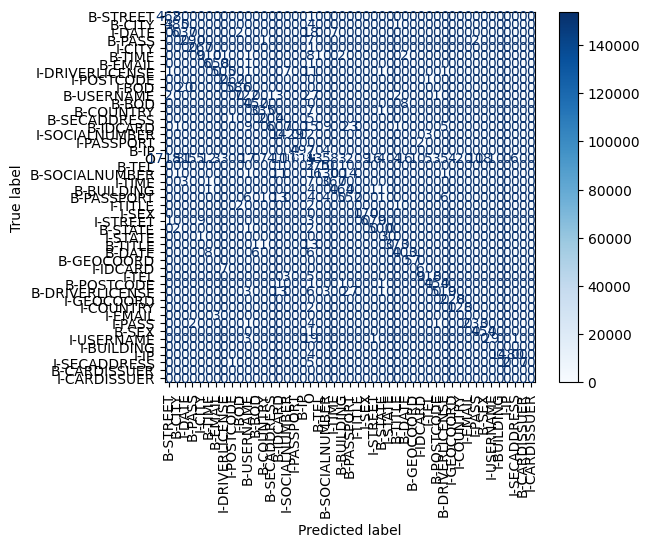

{'precision': np.float64(0.3709394989815245),
 'recall': np.float64(0.9648633575013943),
 'f1': np.float64(0.5358663947755608),
 'accuracy': 0.9057484450151025}

In [12]:
train_encodings = json_to_Dataset_ensemble("datasets/ensemble_train.json")
val_encodings = json_to_Dataset_ensemble("datasets/ensemble_val.json")


model = CubeBert(
    "models/distilbert1",
    "models/albert1",
    freeze_backbones=True,
    labels_to_freeze_alpha=["B-STREET", "I-STREET"],
    label2id=label2id,
    id2label=id2label,
)

train_loader = DataLoader(
    val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch
)
evaluate_model(model, train_loader, "cuda")

Epoch 1:   9%|▊         | 100/1166 [02:21<16:18,  1.09it/s]

Epoch 1, step 100: loss = 0.3073


Epoch 1:  17%|█▋        | 200/1166 [04:43<15:04,  1.07it/s]

Epoch 1, step 200: loss = 0.3600


Epoch 1:  26%|██▌       | 300/1166 [07:07<22:33,  1.56s/it]

Epoch 1, step 300: loss = 0.3451


Epoch 1:  34%|███▍      | 400/1166 [09:27<13:41,  1.07s/it]

Epoch 1, step 400: loss = 0.2932


Epoch 1:  43%|████▎     | 500/1166 [11:51<15:41,  1.41s/it]

Epoch 1, step 500: loss = 0.3993


Epoch 1:  51%|█████▏    | 600/1166 [14:10<14:10,  1.50s/it]

Epoch 1, step 600: loss = 0.4533


Epoch 1:  60%|██████    | 700/1166 [16:40<12:32,  1.61s/it]

Epoch 1, step 700: loss = 0.4584


Epoch 1:  69%|██████▊   | 800/1166 [18:54<09:46,  1.60s/it]

Epoch 1, step 800: loss = 0.3194


Epoch 1:  77%|███████▋  | 900/1166 [21:10<06:26,  1.45s/it]

Epoch 1, step 900: loss = 0.4329


Epoch 1:  86%|████████▌ | 1000/1166 [24:37<07:48,  2.82s/it]

Epoch 1, step 1000: loss = 0.3901


Epoch 1:  94%|█████████▍| 1100/1166 [28:54<02:40,  2.43s/it]

Epoch 1, step 1100: loss = 0.3143


Epoch 1: 100%|██████████| 1166/1166 [31:35<00:00,  1.63s/it]


Epoch 1 completed. Average training loss: 0.3551


100%|██████████| 66/66 [02:27<00:00,  2.23s/it]


               precision    recall  f1-score   support

          BOD       0.98      0.98      0.98       460
     BUILDING       0.99      0.99      0.99       471
         CITY       0.97      0.99      0.98       493
      COUNTRY       0.96      0.98      0.97       343
         DATE       0.93      0.95      0.94       423
DRIVERLICENSE       0.95      0.90      0.93       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.97      1.00      0.98        57
       IDCARD       0.92      0.91      0.91       670
           IP       1.00      0.99      1.00       503
         PASS       0.96      0.96      0.96       300
     PASSPORT       0.90      0.94      0.92       587
     POSTCODE       0.98      0.99      0.99       458
   SECADDRESS       0.95      0.98      0.96       210
          SEX       0.96      1.00      0.98       455
 SOCIALNUMBER       0.94      0.95      0.95       660
        STATE       0.98      0.99      0.99       505
       ST

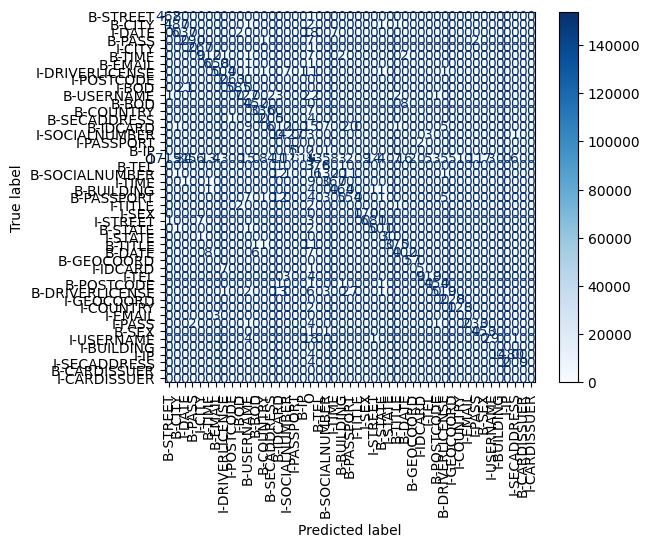

Validation Precision: 0.3715, Recall: 0.9668, F1: 0.5368, Accuracy: 0.9058
Class B-STREET: alpha = 0.54
Class B-CITY: alpha = 0.61
Class I-DATE: alpha = 0.73
Class B-PASS: alpha = 0.44
Class I-CITY: alpha = 0.63
Class B-TIME: alpha = 0.59
Class B-EMAIL: alpha = 0.54
Class I-DRIVERLICENSE: alpha = 0.57
Class I-POSTCODE: alpha = 0.72
Class I-BOD: alpha = 0.54
Class B-USERNAME: alpha = 0.74
Class B-BOD: alpha = 0.57
Class B-COUNTRY: alpha = 0.66
Class B-SECADDRESS: alpha = 0.48
Class B-IDCARD: alpha = 0.64
Class I-SOCIALNUMBER: alpha = 0.60
Class I-PASSPORT: alpha = 0.67
Class B-IP: alpha = 0.53
Class O: alpha = 0.64
Class B-TEL: alpha = 0.62
Class B-SOCIALNUMBER: alpha = 0.77
Class I-TIME: alpha = 0.51
Class B-BUILDING: alpha = 0.50
Class B-PASSPORT: alpha = 0.73
Class I-TITLE: alpha = 0.40
Class I-SEX: alpha = 0.50
Class I-STREET: alpha = 0.63
Class B-STATE: alpha = 0.62
Class I-STATE: alpha = 0.61
Class B-TITLE: alpha = 0.51
Class B-DATE: alpha = 0.71
Class B-GEOCOORD: alpha = 0.58
Cla

Epoch 2:   9%|▊         | 100/1166 [02:35<29:08,  1.64s/it]

Epoch 2, step 100: loss = 0.4183


Epoch 2:  17%|█▋        | 200/1166 [04:47<20:12,  1.26s/it]

Epoch 2, step 200: loss = 0.3625


Epoch 2:  26%|██▌       | 300/1166 [07:09<23:29,  1.63s/it]

Epoch 2, step 300: loss = 0.3861


Epoch 2:  34%|███▍      | 400/1166 [09:25<17:36,  1.38s/it]

Epoch 2, step 400: loss = 0.4095


Epoch 2:  43%|████▎     | 500/1166 [11:57<13:34,  1.22s/it]

Epoch 2, step 500: loss = 0.3483


Epoch 2:  51%|█████▏    | 600/1166 [14:27<12:25,  1.32s/it]

Epoch 2, step 600: loss = 0.2972


Epoch 2:  60%|██████    | 700/1166 [16:59<09:07,  1.18s/it]

Epoch 2, step 700: loss = 0.4133


Epoch 2:  69%|██████▊   | 800/1166 [19:18<11:26,  1.88s/it]

Epoch 2, step 800: loss = 0.4632


Epoch 2:  77%|███████▋  | 900/1166 [21:48<08:31,  1.92s/it]

Epoch 2, step 900: loss = 0.3101


Epoch 2:  86%|████████▌ | 1000/1166 [24:14<03:52,  1.40s/it]

Epoch 2, step 1000: loss = 0.3587


Epoch 2:  94%|█████████▍| 1100/1166 [26:47<01:25,  1.30s/it]

Epoch 2, step 1100: loss = 0.3174


Epoch 2: 100%|██████████| 1166/1166 [28:25<00:00,  1.46s/it]


Epoch 2 completed. Average training loss: 0.3552


100%|██████████| 66/66 [02:12<00:00,  2.01s/it]


               precision    recall  f1-score   support

          BOD       0.98      0.98      0.98       460
     BUILDING       0.98      0.99      0.98       471
         CITY       0.97      0.99      0.98       493
      COUNTRY       0.96      0.98      0.97       343
         DATE       0.93      0.95      0.94       423
DRIVERLICENSE       0.95      0.90      0.93       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.95      1.00      0.97        57
       IDCARD       0.92      0.91      0.91       670
           IP       1.00      0.99      1.00       503
         PASS       0.95      0.96      0.96       300
     PASSPORT       0.90      0.94      0.92       587
     POSTCODE       0.98      0.99      0.99       458
   SECADDRESS       0.95      0.98      0.96       210
          SEX       0.96      1.00      0.98       455
 SOCIALNUMBER       0.95      0.95      0.95       660
        STATE       0.98      0.99      0.99       505
       ST

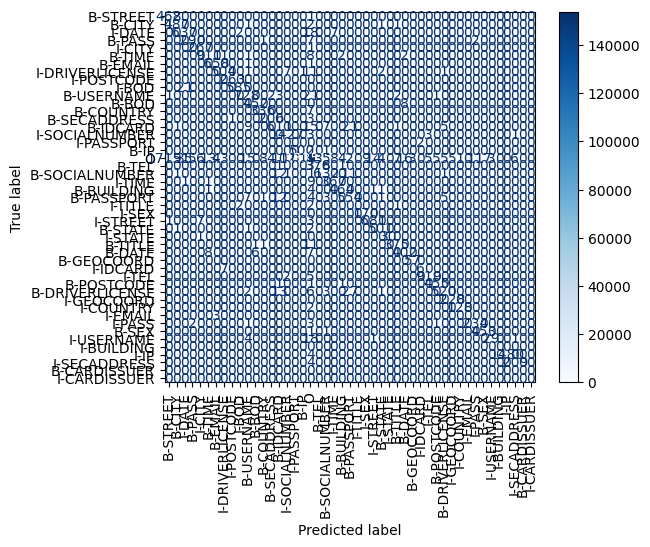

Validation Precision: 0.3715, Recall: 0.9670, F1: 0.5368, Accuracy: 0.9058
Class B-STREET: alpha = 0.52
Class B-CITY: alpha = 0.59
Class I-DATE: alpha = 0.74
Class B-PASS: alpha = 0.43
Class I-CITY: alpha = 0.62
Class B-TIME: alpha = 0.60
Class B-EMAIL: alpha = 0.55
Class I-DRIVERLICENSE: alpha = 0.54
Class I-POSTCODE: alpha = 0.76
Class I-BOD: alpha = 0.55
Class B-USERNAME: alpha = 0.74
Class B-BOD: alpha = 0.58
Class B-COUNTRY: alpha = 0.68
Class B-SECADDRESS: alpha = 0.49
Class B-IDCARD: alpha = 0.61
Class I-SOCIALNUMBER: alpha = 0.60
Class I-PASSPORT: alpha = 0.77
Class B-IP: alpha = 0.50
Class O: alpha = 0.65
Class B-TEL: alpha = 0.61
Class B-SOCIALNUMBER: alpha = 0.79
Class I-TIME: alpha = 0.51
Class B-BUILDING: alpha = 0.57
Class B-PASSPORT: alpha = 0.72
Class I-TITLE: alpha = 0.29
Class I-SEX: alpha = 0.52
Class I-STREET: alpha = 0.73
Class B-STATE: alpha = 0.68
Class I-STATE: alpha = 0.64
Class B-TITLE: alpha = 0.51
Class B-DATE: alpha = 0.73
Class B-GEOCOORD: alpha = 0.64
Cla

Epoch 3:   9%|▊         | 100/1166 [02:23<24:54,  1.40s/it]

Epoch 3, step 100: loss = 0.3518


Epoch 3:  17%|█▋        | 200/1166 [04:48<24:29,  1.52s/it]

Epoch 3, step 200: loss = 0.3861


Epoch 3:  19%|█▊        | 218/1166 [05:18<23:06,  1.46s/it]


KeyboardInterrupt: 

In [10]:
# Initialize model and move to GPU if available
train_encodings = json_to_Dataset_ensemble("datasets/ensemble_train.json")
val_encodings = json_to_Dataset_ensemble("datasets/ensemble_val.json")

train_loader = DataLoader(
    train_encodings, batch_size=16, shuffle=True, collate_fn=collate_batch
)
dev_loader = DataLoader(
    val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch
)


model = CubeBert("models/distilbert1", "models/albert1", freeze_backbones=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare optimizer (all parameters of both sub-models are included)
optimizer = AdamW([model.alpha_logits], lr=1e-2)

num_epochs = 20  # total training budget
patience = 2
best_f1 = 0.0
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    model.train()  # set model to training mode
    total_loss = 0.0
    for step, batch in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch}"), start=1
    ):
        # Move batch data to device
        input_ids_distil = batch["distilbert_inputids"].to(device)
        attention_mask_distil = batch["distilbert_attention_masks"].to(device)
        input_ids_albert = batch["albert_inputids"].to(device)
        attention_mask_albert = batch["albert_attention_masks"].to(device)
        # For training, we can use the subword-aligned labels from one model or the word-level labels.
        # Here we'll use the word-level labels for loss, which our model expects as `labels`.
        labels = batch["spacy_labels"].to(device)
        # Forward pass through the ensemble model
        outputs = model(
            input_ids_distil=input_ids_distil,
            attention_mask_distil=attention_mask_distil,
            input_ids_albert=input_ids_albert,
            attention_mask_albert=attention_mask_albert,
            distil_word_ids=batch["distilbert_wordids"],
            albert_word_ids=batch["albert_wordids"],
            labels=labels,
        )
        loss = outputs["loss"]
        total_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # (Optional) print loss every N steps for monitoring
        if step % 100 == 0:
            print(f"Epoch {epoch}, step {step}: loss = {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} completed. Average training loss: {avg_loss:.4f}")

    # Evaluate on validation set
    eval_metrics = evaluate_model(model, dev_loader, device=device)
    f1 = eval_metrics["f1"]

    print(
        f"Validation Precision: {eval_metrics['precision']:.4f}, Recall: {eval_metrics['recall']:.4f}, "
        f"F1: {f1:.4f}, Accuracy: {eval_metrics['accuracy']:.4f}"
    )

    alpha_values = torch.sigmoid(model.alpha_logits).detach().cpu().numpy()
    for i, a in enumerate(alpha_values):
        print(f"Class {id2label[i]}: alpha = {a:.2f}")

    # Early stopping check
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("New best model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in F1. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break